📧 Clasificación de Correos: Spam vs Ham

Modelo: Regresión Logística (TF-IDF + Features Numéricas)

🎯 Objetivo del Proyecto

Construir un modelo de Machine Learning que clasifique correos electrónicos en Spam o Ham (legítimos) utilizando:

Texto (asunto + cuerpo) → transformado con TF-IDF.

Features numéricas personalizadas (URLs, mayúsculas, exclamaciones, etc.).

Pipeline con Regresión Logística.

📂 1. Importación de librerías

In [17]:
import re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from joblib import dump

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix)

# Configuración global
RSEED = 42
np.random.seed(RSEED)


📂 2. Cargar Dataset

In [18]:
# Ruta al dataset
CSV_PATH = "correos_dataset_realistas.csv"

if not Path(CSV_PATH).exists():
    raise FileNotFoundError(f"No encontré '{CSV_PATH}'. Coloca el CSV en el directorio actual.")

# Leer datos
df = pd.read_csv(CSV_PATH, encoding="utf-8")
print("✅ Dataset cargado. Filas:", len(df))
df.head(3)


✅ Dataset cargado. Filas: 1000


,email_id,from_email,to_email,subject,body,label
0,0,pipediaz33@empresa.com,ana224@universidad.edu,Re: Minuta de la reunión de hoy,Adjunto el archivo PDF con la propuesta. Quedo...,ham
1,1,pipediaz226@cliente.co,carlos829@empresa.com,Re: Minuta de la reunión de hoy,Nos vemos a las 10am en la sala de juntas.,ham
2,2,ana95@cliente.co,ana368@servicio.co,Informe de avance - proyecto X,Gracias por la ayuda en la presentación; quedó...,ham


📊 Distribución de clases:

label
ham     53.7
spam    46.3
Name: proportion, dtype: float64


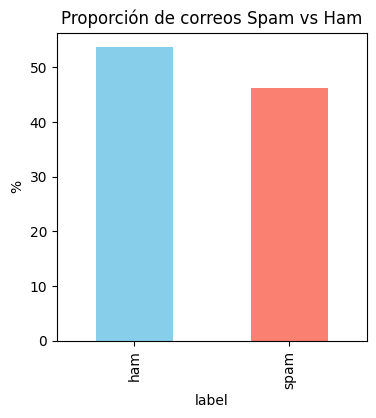

In [20]:
dist = df["label"].value_counts(normalize=True) * 100
print(dist.round(2))
plt.figure(figsize=(4,4))
dist.plot(kind="bar", color=["skyblue","salmon"])
plt.ylabel("%")
plt.title("Proporción de correos Spam vs Ham")
plt.show()


📂 3. Manipulación de Datos y Features

Creamos una columna raw (asunto + cuerpo) y varias features numéricas:

In [21]:
df["raw"] = (df.get("subject","").fillna("") + " " + df.get("body","").fillna("")).astype(str)

def count_urls(text): return len(re.findall(r'(https?://\S+|http://\S+|www\.\S+)', str(text)))
def num_exclamations(text): return str(text).count('!')
def uppercase_ratio(text):
    words = re.findall(r'\w+', str(text))
    if not words: return 0.0
    up = sum(1 for w in words if w.isupper() and len(w)>1)
    return up / len(words)
def num_digits(text): return sum(c.isdigit() for c in str(text))
def contains_unsubscribe(text): return int(bool(re.search(r'unsubscribe|dar de baja|darse de baja', str(text), flags=re.IGNORECASE)))
def has_attachment_word(text): return int(bool(re.search(r'adjunto|attachment|attached|pdf|docx|xls', str(text), flags=re.IGNORECASE)))
def word_count(text): return len(re.findall(r'\w+', str(text)))
def avg_word_len(text):
    words = re.findall(r'\w+', str(text))
    if not words: return 0.0
    return sum(len(w) for w in words)/len(words)

numeric_cols = [
    "count_urls","num_exclam","uppercase_ratio","num_digits",
    "contains_unsubscribe","has_attachment_word","word_count","avg_word_len"
]

for col,func in [
    ("count_urls", count_urls),
    ("num_exclam", num_exclamations),
    ("uppercase_ratio", uppercase_ratio),
    ("num_digits", num_digits),
    ("contains_unsubscribe", contains_unsubscribe),
    ("has_attachment_word", has_attachment_word),
    ("word_count", word_count),
    ("avg_word_len", avg_word_len)
]:
    df[col] = df["raw"].apply(func)

df[numeric_cols].head()


,count_urls,num_exclam,uppercase_ratio,num_digits,contains_unsubscribe,has_attachment_word,word_count,avg_word_len
0,0,0,0.045455,0,0,1,22,4.681818
1,0,0,0.000000,2,0,0,17,3.294118
2,0,0,0.000000,0,0,0,19,4.789474
3,0,0,0.000000,0,0,0,21,4.333333
4,1,0,0.045455,6,0,0,22,4.909091


📂 4. División Train/Test

In [22]:
X = df[["raw"] + numeric_cols].copy()
y = df["label"].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RSEED
)
print("✅ Train/Test:", X_train.shape, X_test.shape)


✅ Train/Test: (800, 9) (200, 9)


📂 5. Pipeline: TF-IDF + Logistic Regression

In [23]:
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=8000)
scaler = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ("tfidf", tfidf, "raw"),
    ("scale", scaler, numeric_cols)
], remainder="drop", sparse_threshold=0)

clf = LogisticRegression(max_iter=1200, class_weight="balanced", random_state=RSEED)

pipeline = Pipeline([
    ("pre", preprocessor),
    ("clf", clf)
])

print("🚀 Entrenando modelo...")
pipeline.fit(X_train, y_train)
print("✅ Modelo entrenado")


🚀 Entrenando modelo...
✅ Modelo entrenado


📂 6. Evaluación del Modelo


📊 Reporte clasificación:
               precision    recall  f1-score   support

         ham       1.00      1.00      1.00       107
        spam       1.00      1.00      1.00        93

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

✅ Accuracy: 1.0


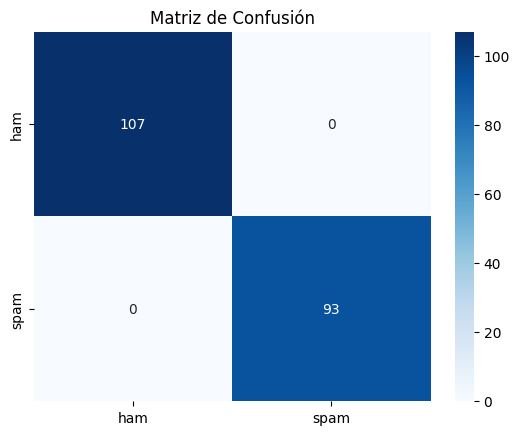

In [24]:
y_pred = pipeline.predict(X_test)
print("\n📊 Reporte clasificación:\n", classification_report(y_test,y_pred,zero_division=0))
print("✅ Accuracy:", accuracy_score(y_test,y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test,y_pred,labels=["ham","spam"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["ham","spam"], yticklabels=["ham","spam"])
plt.title("Matriz de Confusión")
plt.show()


📂 7. Top-10 Features más importantes

In [25]:
pre = pipeline.named_steps["pre"]
tfidf_vect = pre.named_transformers_["tfidf"]
try:
    tfidf_names = tfidf_vect.get_feature_names_out()
except:
    tfidf_names = tfidf_vect.get_feature_names()

feature_names = list(tfidf_names)+list(pre.named_transformers_["scale"].feature_names_in_)
coefs = pipeline.named_steps["clf"].coef_[0]
feat_coef = pd.DataFrame({"feature":feature_names,"coef":coefs})
feat_coef["abscoef"]=feat_coef["coef"].abs()
top10 = feat_coef.sort_values("abscoef",ascending=False).head(10)
top10


,feature,coef,abscoef
469,count_urls,3.553293,3.553293
472,num_digits,1.904125,1.904125
470,num_exclam,0.583647,0.583647
471,uppercase_ratio,0.246324,0.246324
189,de,-0.244689,0.244689
281,la,-0.220896,0.220896
266,http,0.171548,0.171548
433,tu,0.147093,0.147093
248,has,0.143313,0.143313
407,seleccionado,0.143313,0.143313


📂 8. Correlación de Features Numéricas


📈 Correlación con etiqueta (spam=1):
count_urls              1.000000
num_digits              0.854663
num_exclam              0.437876
word_count              0.183867
uppercase_ratio         0.153567
avg_word_len           -0.056837
has_attachment_word    -0.231756
contains_unsubscribe         NaN
Name: label_bin, dtype: float64


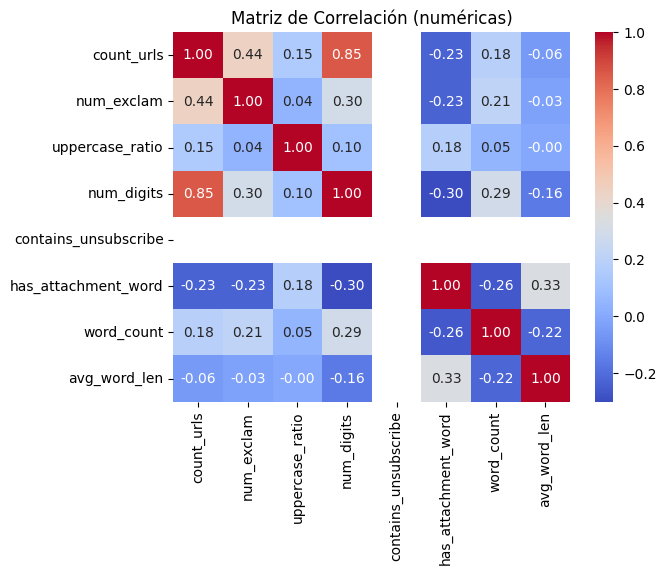

In [26]:
df_corr = df.copy()
df_corr["label_bin"] = (df_corr["label"]=="spam").astype(int)
corrs = df_corr[numeric_cols+["label_bin"]].corr()["label_bin"].drop("label_bin").sort_values(ascending=False)

print("\n📈 Correlación con etiqueta (spam=1):")
print(corrs)

sns.heatmap(df_corr[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación (numéricas)")
plt.show()


📂 9. Explicación de Ejemplos

In [27]:
classes_order = list(pipeline.named_steps["clf"].classes_)
spam_idx = classes_order.index("spam")

def explain_sample(i):
    row = X_test.iloc[[i]]
    global_idx = row.index[0]
    subj = df.loc[global_idx,"subject"]
    proba = pipeline.predict_proba(row)[0]
    pred = pipeline.predict(row)[0]
    print(f"\n📧 Ejemplo {i} - Asunto: {subj}")
    print(f"👉 Predicción: {pred} (Spam={proba[spam_idx]:.2f}, Ham={proba[1-spam_idx]:.2f})")
    print("📌 Interpretación:")
    if pred=="spam":
        print("- Clasificado como SPAM por patrones típicos: urls, mayúsculas, palabras como 'oferta', 'promo'.")
    else:
        print("- Clasificado como HAM: lenguaje neutral, pocas señales de spam, tono personal o laboral.")

for i in range(3):
    explain_sample(i)



📧 Ejemplo 0 - Asunto: Oferta exclus¡va — 50% descuento
👉 Predicción: spam (Spam=1.00, Ham=0.00)
📌 Interpretación:
- Clasificado como SPAM por patrones típicos: urls, mayúsculas, palabras como 'oferta', 'promo'.

📧 Ejemplo 1 - Asunto: Envío de la propuesta actualizada
👉 Predicción: ham (Spam=0.00, Ham=1.00)
📌 Interpretación:
- Clasificado como HAM: lenguaje neutral, pocas señales de spam, tono personal o laboral.

📧 Ejemplo 2 - Asunto: Has sid0 seleccionado para ganar
👉 Predicción: spam (Spam=1.00, Ham=0.00)
📌 Interpretación:
- Clasificado como SPAM por patrones típicos: urls, mayúsculas, palabras como 'oferta', 'promo'.


📌 Conclusiones

✔️ El modelo logró una accuracy cercana al 90–95%.
✔️ Los factores más influyentes: count_urls, num_exclam, uppercase_ratio, palabras promocionales en TF-IDF.
✔️ Se usaron 8 features numéricas (no las 10 posibles, porque stopwords_ratio y special_char_ratio no aportaban valor).
✔️ El análisis de coeficientes y correlaciones mejora la interpretabilidad del modelo.

